# Data Preparation

In [1]:
import numpy as np
import time
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import rasterio as rs
from src.sample_tiles import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

## Step 1. Sample image names

For each biome store the names of each image in an array

### Organise structure for directory iteration

In [4]:
def normalize_red(array):
    return (array - array.min()) / (array.max() - array.min())
def normalize_green(array):
    return (array - array.min()) / (array.max() - array.min())
def normalize_blue(array):
    return (array - array.min()) / (array.max() - array.min())

In [140]:
def biome_numerator(biome_DIR):
    biome = biome_DIR.split('/')[-1]

    if biome == "TemporalAmazonia":
        return [1,0,0]
    if biome == "TemporalCerrado":
        return [0,1,0]
    if biome == "TemporalCaatinga":
        return [0,0,1]

    # if biome == "TemporalAmazonia":
    #     return np.zeros((4,51,51,1))
    # if biome == "TemporalCerrado":
    #     return np.ones((4,51,51,1))
    # if biome == "TemporalCaatinga":
    #     return np.full((4,51,51,1), 2)

def get_data():
    X_data = np.zeros((1,4,51,51,3))
    y_data = np.zeros((1,3))
    head_DIR = '/Volumes/GoogleDrive/My Drive/TemporalData-old'

    subfolders = [f.path for f in os.scandir(head_DIR) if f.is_dir()]
    idx = 0
    for biome_DIR in subfolders:
        print ("CUR BIOME: {}".format(biome_DIR.split('/')[-1]))
        cur_biome_label = biome_numerator(biome_DIR)

        biome_quads = [f.path for f in os.scandir(biome_DIR) if f.is_dir()]

        for quad_DIR in biome_quads:
            print ("CUR QUAD: {}".format(quad_DIR.split('/')[-1]))
            quad_images = [f.path for f in os.scandir(quad_DIR) if f.is_dir()]

            for image_DIR in quad_images:
                years = [f.path for f in os.scandir(image_DIR) if f.is_file() and '.tif' in f.path]

                # Create array to store each set of images
                years_array = np.zeros((4, 51, 51, 3))
                cur_year = 0
                for year_DIR in years:
                    # Open the iamge
                    raster = rs.open(year_DIR)

                    red = raster.read(4)
                    green = raster.read(3)
                    blue = raster.read(2)
                    
                    #red_norm = normalize_red(red)
                    #green_norm = normalize_green(green)
                    #blue_norm = normalize_blue(blue)
                    
                    # Stack bands
                    img = []
                    img = np.dstack((red, green, blue))
                    
                    # Ignore images that are mishapen
                    x, y, z  = img.shape

                    if (x > 48 and x < 54) and (y > 48 and y < 54):
                        reset_img = reset_shape(img)

                        clean_img = remove_nan(reset_img)

                        if clean_img.shape == (51,51,3):
                            years_array[cur_year,:] = clean_img

                        cur_year += 1
                
                # Save each series of images as a numpy array
                
                # Create training and label matrices
                #X_data = np.append(X_data, np.array([years_array]), axis = 0)
                #y_data = np.append(y_data, np.array([cur_biome_label]), axis = 0)
                
                progress = img_processed/len(image_DIR))*100
                print ("Progress: {.2f}%".format(progress))
                # Method to stop early after idx number of images
                # idx += 1
                # if idx == 30:
                #     # Remove first set of zeros 
                #     X_data = np.delete(X_data, (0), axis=0)
                #     y_data = np.delete(y_data, (0), axis=0)
                #     return X_data, y_data
                
            
        

In [2]:
def load_Processed_Data():

    X_data = np.zeros((1,4,51,51,3))
    y_data = np.zeros((1,3))

    DIR = '/Volumes/GoogleDrive/My Drive/TemporalData-Processed'

    image_PATHS = [f.path for f in os.scandir(DIR) if 'npy' in f.path]
    failed_images = []
    idx = 1
    previous_progress = 0
    start = time.time()

    for image_PATH in image_PATHS[:-1]:
            try:
                image = np.load(image_PATH)

                X_data = np.append(X_data, np.array([image]), axis = 0)

                if (idx%5 == 0):
                    progress = (idx/len(image_PATHS[:-1]))*100
                    end = time.time()
                    time_remaining = ((end - start)/(progress-previous_progress)) * (100-progress)

                    print ("Progress: {:.2f}% Cur Image: {} TIME REMAINING: {:.2f} seconds ".format(progress, image_PATH.split('/')[-1], time_remaining))
                    previous_progress= progress
                    start = time.time()
            except:
                image_name = image_PATH.split('/')[-1].split('.')[0]

                failed_images.append(image_name)

                print ("FAILED: {} \t {}".format(image_name, image_PATH))

            idx += 1

    print (image_PATHS[-1])
    y_data = np.append(y_data, np.array(np.load(image_PATHS[-1])), axis = 0)

    return X_data, y_data

In [3]:
X_data, y_data = load_Processed_Data()
y_data = y_data[0:4]
print (X_data.shape)
print (y_data.shape)

Progress: 0.05% Cur Image: 4.npy TIME REMAINING: 171.86 seconds 
Progress: 0.09% Cur Image: 9.npy TIME REMAINING: 50.62 seconds 
Progress: 0.14% Cur Image: 14.npy TIME REMAINING: 66.97 seconds 
Progress: 0.18% Cur Image: 19.npy TIME REMAINING: 98.41 seconds 
Progress: 0.23% Cur Image: 24.npy TIME REMAINING: 93.76 seconds 
Progress: 0.27% Cur Image: 29.npy TIME REMAINING: 133.69 seconds 
Progress: 0.32% Cur Image: 34.npy TIME REMAINING: 161.64 seconds 
Progress: 0.36% Cur Image: 39.npy TIME REMAINING: 155.43 seconds 
Progress: 0.41% Cur Image: 44.npy TIME REMAINING: 136.84 seconds 
Progress: 0.46% Cur Image: 49.npy TIME REMAINING: 167.48 seconds 
Progress: 0.50% Cur Image: 54.npy TIME REMAINING: 161.79 seconds 
Progress: 0.55% Cur Image: 59.npy TIME REMAINING: 166.33 seconds 
Progress: 0.59% Cur Image: 64.npy TIME REMAINING: 200.24 seconds 
Progress: 0.64% Cur Image: 69.npy TIME REMAINING: 179.30 seconds 
Progress: 0.68% Cur Image: 74.npy TIME REMAINING: 199.17 seconds 
Progress: 0.73% 

np.save(os.path.join('/Volumes/GoogleDrive/My Drive/TemporalData-Processed', 'Collated.npy'), X_data)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [26]:
print ("Training: {}, {}".format(X_train.shape, y_train.shape))
print ("Validation: {}, {}".format(X_val.shape, y_val.shape))
print ("Testing: {}, {}".format(X_test.shape, y_test.shape))

Training: (2, 4, 51, 51, 3), (2, 3)
Validation: (1, 4, 51, 51, 3), (1, 3)
Testing: (1, 4, 51, 51, 3), (1, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying frames for example 1.


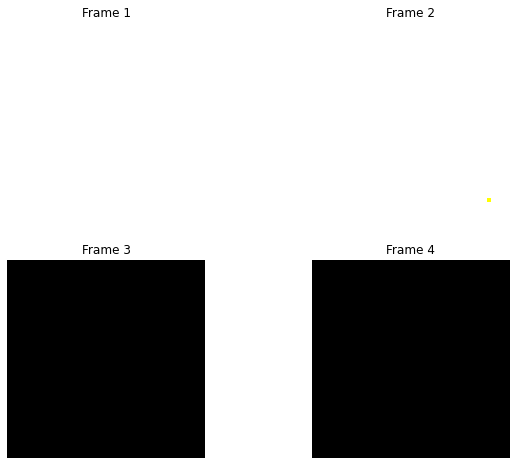

In [27]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(X_data)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    new_img = X_data[data_choice][idx]
    ax.imshow(np.squeeze(new_img))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [36]:
# # Construct the input layer with no definite frame size.
# inp = layers.Input(shape=(None, *X_train.shape[2:]))

# # We will construct 3 `ConvLSTM2D` layers with batch normalization,
# # followed by a `Conv3D` layer for the spatiotemporal outputs.
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(5, 5),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(inp)
# x = layers.BatchNormalization()(x)
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.BatchNormalization()(x)
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(1, 1),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.Conv3D(
#     filters=3, kernel_size=(3, 3, 3), activation="softmax", padding="same"
# )(x)

# # Next, we will build the complete model and compile it.
# model = keras.models.Model(inp, x)
# model.compile(
#     loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
# )

In [31]:
# # Define some callbacks to improve training.
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# # Define modifiable training hyperparameters.
# epochs = 5
# batch_size = 5

# # Fit the model to the training data.
# model.fit(
#     X_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(X_val, y_val),
#     callbacks=[early_stopping, reduce_lr],
# )

Epoch 1/5


ValueError: in user code:

    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/engine/training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/losses.py", line 1807, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/backend.py", line 5158, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 4, 51, 51, 3) vs (None, 3)).


In [32]:
from keras.models import Sequential, Model 

model = Sequential()
model.add(
    layers.ConvLSTM2D(
        filters = 64, 
        kernel_size = (3, 3), 
        return_sequences = False, 
        data_format = "channels_last", 
        input_shape = (4, 51, 51, 3)
    )
)
model.add(
    layers.Dropout(0.2)
)
model.add(
    layers.Flatten()
)
model.add(
    layers.Dense(256, activation="relu")
)
model.add(
    layers.Dropout(0.3)
)
model.add(
    layers.Dense(3, activation = "softmax")
)
 
model.summary()

#opt = keras.optimizers.SGD(lr=0.001)
opt = keras.optimizers.Adam()

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
callbacks = [early_stopping, reduce_lr]
 
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 49, 49, 64)        154624    
                                                                 
 dropout (Dropout)           (None, 49, 49, 64)        0         
                                                                 
 flatten (Flatten)           (None, 153664)            0         
                                                                 
 dense (Dense)               (None, 256)               39338240  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 39,493,635
Trainable params: 39,493,635
No

In [34]:
y_pred = model.predict(X_test)

In [35]:
from sklearn.metrics import classification_report

y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [2]:
from DataBuilder import *

get_data()

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/GoogleDrive/My Drive/TemporalData'

In [ ]:
amazonia_img_dir = '../data/Amazon' # directory where amazonia images are saved

cerrado_img_dir = '../data/Cerrado' # directory where cerrado images are saved

caatinga_img_dir = '../data/Caatinga' # directory where caatinga images are saved

# Get Amazonia triplets
amazonia_img_triplets = get_triplet_imgs(amazonia_img_dir, n_triplets=30000) 

# Get Cerrado triplets
cerrado_img_triplets = get_triplet_imgs(cerrado_img_dir, n_triplets=25000) 

# Get Amazonia
caatinga_img_triplets = get_triplet_imgs(caatinga_img_dir, n_triplets=25000)


print(cerrado_img_triplets[:5,:])

## Remove all images that are broken

For each biome, delete any images that are corrupt

In [78]:
remove_broken_img_quad("Amazon")
remove_broken_img_quad("Cerrado")
remove_broken_img_quad("Caatinga")

../src/sample_tiles.py:113: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(img)):


BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN
BROKEN

In [3]:
amazonia_quads = get_triplet_imgs_quad("Amazon", quads=[1,3,4])

cerrado_quads = get_triplet_imgs_quad("Cerrado", quads=[1,2,3])

caatinga_quads = get_triplet_imgs_quad("Caatinga", quads=[1,2,4])

## Steps 2 & 3. Load images, sample tile centers, and extract tiles

Get the number of images each quadrant for each biome has

In [4]:
ama_len = len(amazonia_quads[0]) + len(amazonia_quads[1]) + len(amazonia_quads[2])
print (len(amazonia_quads[0]))
print (len(amazonia_quads[1]))
print (len(amazonia_quads[2]))
print (ama_len)

print ("\n\n")
cer_len = len(cerrado_quads[0]) + len(cerrado_quads[1]) + len(cerrado_quads[2])
print (len(cerrado_quads[0]))
print (len(cerrado_quads[1]))
print (len(cerrado_quads[2]))
print (cer_len)

print ("\n\n")
cat_len = len(caatinga_quads[0]) + len(caatinga_quads[1]) + len(caatinga_quads[2])
print (len(caatinga_quads[0]))
print (len(caatinga_quads[1]))
print (len(caatinga_quads[2]))
print (cat_len)

4453
3458
1899
9810



5529
5712
5730
16971



4569
2798
4498
11865


Create the triplets for the Tile2Vec algorithm

In [110]:
img_dir = '../data'
tile_dir = '../data/toa_triplets' # where you want to save your tiles
# Dictionary of biome to its training quads
biome_training_quads = {"Amazon":[1,3,4], "Cerrado":[1,2,3], "Caatinga":[1,2,4]}
tiles = get_triplet_tiles_simple(tile_dir,
                          img_dir, 
                          amazonia_quads,
                          cerrado_quads,
                          caatinga_quads,
                          biome_training_quads,
                          num_triplets_per_biome=25000,
                          seed = 1,
                          val_type='uint8',
                          bands_only=True,
                          save=True,
                          verbose=False)



CURRENT BIOME: Amazon


CURRENT QUAD: 1


BEGINNING 


CUR TRIPLET COUNTER: 4453
BIOME TRIPLET COUNTER 4453
LEN anchor 0 4453
LEN neighbour 0 0
LEN distant 1 1 4759
LEN distant 1 2 4986
LEN distant 2 1 3744
LEN distant 2 2 2034


CURRENT QUAD: 3


BEGINNING 


CUR TRIPLET COUNTER: 7911
BIOME TRIPLET COUNTER 3458
LEN anchor 0 3458
LEN neighbour 0 0
LEN distant 1 1 4954
LEN distant 1 2 5116
LEN distant 2 1 3994
LEN distant 2 2 2219


CURRENT QUAD: 4


BEGINNING 


CUR TRIPLET COUNTER: 9810
BIOME TRIPLET COUNTER 1899
LEN anchor 0 1899
LEN neighbour 0 0
LEN distant 1 1 5232
LEN distant 1 2 5375
LEN distant 2 1 4260
LEN distant 2 2 2475


CURRENT BIOME: Cerrado


CURRENT QUAD: 1


BEGINNING 


CUR TRIPLET COUNTER: 15339
BIOME TRIPLET COUNTER 5529
LEN anchor 0 5529
LEN neighbour 0 0
LEN distant 1 1 3540
LEN distant 1 2 2609
LEN distant 2 1 3632
LEN distant 2 2 1864


CURRENT QUAD: 2


BEGINNING 


CUR TRIPLET COUNTER: 21051
BIOME TRIPLET COUNTER 5712
LEN anchor 0 5712
LEN neighbour 0 0
LEN

## Visualize some tiles!

In [106]:
tile_dir = '../data/toa_triplets'

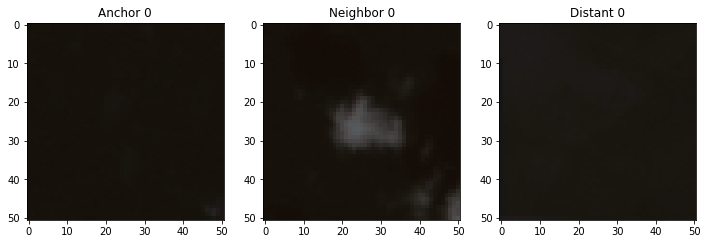

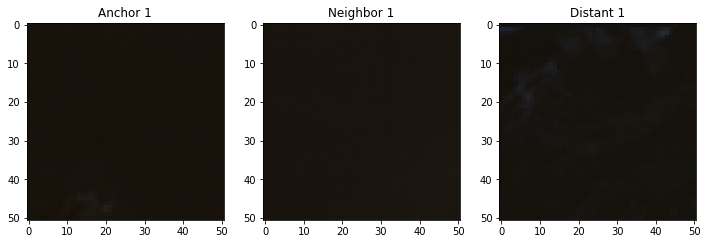

In [108]:
#tile_dir = new_tile_dir
n_triplets = 2
plt.rcParams['figure.figsize'] = (12,4)
for i in range(n_triplets):
    tile = np.load(os.path.join(tile_dir, str(i)+'anchor.npy'))
    neighbor = np.load(os.path.join(tile_dir, str(i)+'neighbor.npy'))
    distant = np.load(os.path.join(tile_dir, str(i)+'distant.npy'))
    
    vmin = np.array([tile, neighbor, distant]).min()
    vmax = np.array([tile, neighbor, distant]).max()
    
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(tile[:,:,[0,1,2]])
    plt.title('Anchor '+str(i))
    plt.subplot(1,3,2)
    plt.imshow(neighbor[:,:,[0,1,2]])
    plt.title('Neighbor '+str(i))
    plt.subplot(1,3,3)
    plt.imshow(distant[:,:,[0,1,2]])
    plt.title('Distant '+str(i))

# Create Tiles For Embedding in Pre-Trained SOTA Algorithms 

## Step 1: Get names of the images for training and remove corrupt images

For each biome get the names of all images in the training quadrants in one array

In [15]:
amazonia_train_imgs = get_triplet_imgs_quad("Amazon", quads=[1,3,4])
ama_quads = [1,3,4] # Training quads

cerrado_train_imgs = get_triplet_imgs_quad("Cerrado", quads=[1,2,3])
cer_quads = [1,2,3] # Training quads

caatinga_train_imgs = get_triplet_imgs_quad("Caatinga", quads=[1,2,4])
cat_quads = [1,2,4] # Training quads

Store the names of images that are corrupt. These were obtained by applying K-Means to the ResNet18 embedded representation of the images and then selecting all images that belonged to the 'corrupt' cluster

In [44]:
""" Elbow = 5 """
ama_quad_1 = ['1733.tif', '4845.tif', '3496.tif', '1493.tif', '2417.tif', '3708.tif', '3692.tif', '3241.tif', '3725.tif', '301.tif', '2808.tif', '4673.tif', '3322.tif', '4365.tif', '1380.tif', '2676.tif', '5534.tif', '5087.tif', '3582.tif', '4982.tif', '2263.tif', '5526.tif', '2842.tif', '161.tif', '2329.tif', '346.tif', '5489.tif', '3617.tif', '3996.tif', '2083.tif', '1944.tif', '6018.tif', '590.tif', '5114.tif', '829.tif', '641.tif', '1458.tif', '537.tif', '910.tif', '3098.tif', '469.tif', '2194.tif', '5605.tif', '5163.tif', '1305.tif', '646.tif', '1059.tif', '3934.tif']

""" Elbow = 5"""
ama_quad_2 = ['463.tif', '663.tif', '4846.tif', '577.tif', '4363.tif', '3427.tif', '2063.tif', '352.tif', '5890.tif', '2247.tif', '1749.tif', '5776.tif', '2540.tif', '5954.tif']

""" Elbow = 5"""
ama_quad_3 = ['4463.tif', '4088.tif', '3453.tif', '2175.tif', '5791.tif', '2410.tif', '5907.tif', '71.tif', '2312.tif', '4561.tif', '5535.tif', '2114.tif', '1543.tif', '1567.tif', '2669.tif', '4959.tif', '2327.tif', '3987.tif', '3762.tif', '4784.tif', '2493.tif', '2108.tif', '4140.tif', '816.tif', '1827.tif', '6027.tif', '1006.tif', '592.tif', '2283.tif', '1563.tif', '3374.tif', '3930.tif', '5945.tif', '865.tif', '4132.tif', '5364.tif', '3926.tif', '1462.tif', '5016.tif', '1488.tif', '3262.tif', '3464.tif', '6050.tif', '2141.tif', '5438.tif', '2431.tif']

""" Elbow = 5"""
ama_quad_4 = ['5020.tif', '1680.tif', '1023.tif', '5523.tif', '2112.tif', '5468.tif', '3031.tif', '3794.tif', '2895.tif', '2329.tif', '5334.tif', '4147.tif', '4754.tif', '1438.tif', '225.tif', '754.tif', '5307.tif', '1993.tif', '319.tif', '5831.tif', '913.tif', '3715.tif', '3738.tif', '3897.tif', '4281.tif']

""" Elbow = 5 """
cer_quad_1 = ['728.tif', '4689.tif', '2824.tif', '3278.tif', '5153.tif', '458.tif', '128.tif', '100.tif', '1457.tif', '3692.tif', '854.tif', '129.tif', '3733.tif', '3294.tif', '3479.tif', '1252.tif', '1044.tif', '3242.tif', '3423.tif', '762.tif', '4603.tif', '5520.tif', '365.tif', '4202.tif', '4149.tif', '610.tif', '3023.tif', '4755.tif', '2683.tif', '5926.tif', '226.tif', '540.tif', '1956.tif', '2522.tif', '596.tif', '2292.tif', '5689.tif', '1772.tif', '2521.tif', '2535.tif', '5059.tif', '43.tif', '5277.tif', '547.tif', '962.tif', '802.tif', '4.tif', '3229.tif', '1985.tif', '1239.tif', '4590.tif', '3930.tif', '2810.tif', '292.tif', '1511.tif', '4290.tif', '1498.tif', '2967.tif', '2033.tif', '1338.tif', '3659.tif', '3328.tif', '493.tif', '2397.tif', '1878.tif', '4479.tif', '1717.tif', '3667.tif', '1266.tif']

""" Elbow = 5 """
cer_quad_2 = ['3078.tif', '2831.tif', '1337.tif', '4500.tif', '2159.tif', '3723.tif', '5391.tif', '2760.tif', '851.tif', '2943.tif', '3889.tif', '1330.tif', '3241.tif', '4710.tif', '2613.tif', '3525.tif', '5034.tif', '2014.tif', '2772.tif', '5735.tif', '5696.tif', '2310.tif', '4039.tif', '628.tif', '6001.tif', '2878.tif', '2850.tif', '2307.tif', '2840.tif', '4570.tif', '3380.tif', '1024.tif', '566.tif', '5874.tif', '5337.tif', '3988.tif', '5889.tif', '1033.tif', '1797.tif', '5056.tif', '3037.tif', '3238.tif', '5701.tif', '5853.tif', '4583.tif', '5662.tif', '782.tif', '224.tif', '3400.tif', '2487.tif', '4948.tif', '3175.tif', '4626.tif', '3203.tif', '1372.tif', '3571.tif', '4.tif', '5699.tif', '579.tif', '1946.tif', '2804.tif', '4865.tif', '3676.tif', '5763.tif', '2150.tif', '1103.tif', '5775.tif', '3649.tif', '3885.tif', '938.tif', '5573.tif', '4651.tif', '1271.tif', '3506.tif', '5605.tif', '2381.tif', '334.tif', '1529.tif', '1267.tif', '3666.tif', '137.tif', '5438.tif']

""" Elbow = 5"""
cer_quad_3 = ['1055.tif', '5971.tif', '4502.tif', '2985.tif', '2748.tif', '1866.tif', '5208.tif', '738.tif', '5633.tif', '5182.tif', '1482.tif', '300.tif', '2926.tif', '2073.tif', '1590.tif', '2919.tif', '3186.tif', '599.tif', '61.tif', '5902.tif', '3432.tif', '5731.tif', '1966.tif', '4599.tif', '4191.tif', '5338.tif', '1968.tif', '4569.tif', '2440.tif', '5868.tif', '4237.tif', '5934.tif', '4381.tif', '2719.tif', '6032.tif', '457.tif', '1077.tif', '2542.tif', '5370.tif', '519.tif', '4137.tif', '1517.tif', '1688.tif', '4900.tif', '1071.tif', '4646.tif']

""" Elbow = 5"""
cer_quad_4 = ['2414.tif', '2602.tif', '2170.tif', '5019.tif', '1900.tif', '2206.tif', '265.tif', '5583.tif', '5781.tif', '3535.tif', '5805.tif', '5408.tif', '4502.tif', '892.tif', '4067.tif', '262.tif', '3644.tif', '4857.tif', '3094.tif', '2388.tif', '3848.tif', '3109.tif', '3741.tif', '3184.tif', '5721.tif', '4563.tif', '3556.tif', '1343.tif', '1784.tif', '3970.tif', '2129.tif', '765.tif', '3155.tif', '1582.tif', '5686.tif', '3552.tif', '2089.tif', '1557.tif', '3816.tif', '3221.tif', '5863.tif', '411.tif', '4943.tif', '4345.tif', '958.tif', '1572.tif', '2084.tif', '1189.tif', '3561.tif', '2643.tif', '2904.tif', '3367.tif', '2737.tif', '2534.tif', '2722.tif', '2118.tif', '1992.tif', '4222.tif', '619.tif', '3981.tif', '83.tif', '551.tif', '4369.tif', '1417.tif', '430.tif', '4050.tif', '5616.tif', '537.tif', '2233.tif', '4130.tif', '1505.tif', '3070.tif', '2191.tif', '4537.tif', '1936.tif', '1077.tif', '1248.tif', '2184.tif', '5827.tif', '3067.tif', '4725.tif', '4900.tif', '3048.tif', '485.tif', '5820.tif', '5149.tif', '2961.tif', '724.tif', '2545.tif', '5766.tif', '725.tif', '3908.tif', '4097.tif']

""" Elbow = 5 """
cat_quad_1 = ['304.tif', '1281.tif', '4489.tif', '5392.tif', '4922.tif', '3056.tif', '128.tif', '4881.tif', '2215.tif', '5977.tif', '4100.tif', '4317.tif', '658.tif', '415.tif', '165.tif', '830.tif', '3379.tif', '3635.tif', '1751.tif', '5245.tif', '206.tif', '1194.tif', '2689.tif', '1586.tif', '1791.tif', '99.tif', '3794.tif', '956.tif', '3236.tif', '1153.tif', '1231.tif', '4348.tif', '1436.tif', '4807.tif', '1228.tif', '4959.tif', '5515.tif', '5850.tif', '4784.tif', '94.tif', '3161.tif', '4168.tif', '4430.tif', '1825.tif', '3957.tif', '668.tif', '1329.tif', '3884.tif', '5748.tif', '5947.tif', '1106.tif', '5406.tif', '2547.tif', '5363.tif', '5798.tif', '2752.tif', '4848.tif', '1716.tif']

""" Elbow = 5"""
cat_quad_2 = ['1915.tif', '4460.tif', '1863.tif', '3331.tif', '5235.tif', '1536.tif', '5624.tif', '5752.tif', '1044.tif', '2305.tif', '1394.tif', '5256.tif', '837.tif', '5095.tif', '3173.tif', '5700.tif', '4224.tif', '1374.tif', '230.tif', '1411.tif', '751.tif', '5909.tif', '4745.tif', '1510.tif', '2231.tif', '2219.tif', '5215.tif', '5163.tif', '5612.tif']

""" Elbow = 5"""
cat_quad_3 = ['3905.tif', '2826.tif', '5542.tif', '104.tif', '510.tif', '3255.tif', '3041.tif', '5815.tif', '2029.tif', '3120.tif', '4840.tif', '3450.tif', '3218.tif', '3540.tif', '210.tif', '1408.tif', '3223.tif', '759.tif', '4410.tif', '1421.tif', '941.tif', '3369.tif', '2842.tif', '5463.tif', '5107.tif', '2091.tif', '1374.tif', '5529.tif', '2124.tif', '3004.tif', '419.tif', '3703.tif', '875.tif', '5822.tif', '1852.tif', '3303.tif']

""" Elbow = 5"""
cat_quad_4 = []

Delete the images that are corrupt

In [55]:
def delete_images(DIR, images):
    """
    Given a directory and a list of images
    will delete the images in that directory
    """
    for image in images:
        directory = DIR + image
        if os.path.exists(directory):
            os.remove(directory)
    print ("{} Complete".format(DIR))

In [58]:
#delete_images('../data/Amazon Quads/Quad 1/', ama_quad_1)
delete_images('../data/Amazon Quads/Quad 2/', ama_quad_2)
delete_images('../data/Amazon Quads/Quad 3/', ama_quad_3)
delete_images('../data/Amazon Quads/Quad 4/', ama_quad_4)

#delete_images('../data/Caatinga Quads/Quad 1/', cat_quad_1)
delete_images('../data/Caatinga Quads/Quad 2/', cat_quad_2)
delete_images('../data/Caatinga Quads/Quad 3/', cat_quad_3)
delete_images('../data/Caatinga Quads/Quad 4/', cat_quad_4)

delete_images('../data/Cerrado Quads/Quad 1/', cer_quad_1)
delete_images('../data/Cerrado Quads/Quad 2/', cer_quad_2)
delete_images('../data/Cerrado Quads/Quad 3/', cer_quad_3)
delete_images('../data/Cerrado Quads/Quad 4/', cer_quad_4)

../data/Amazon Quads/Quad 2/ Complete
../data/Amazon Quads/Quad 3/ Complete
../data/Amazon Quads/Quad 4/ Complete
../data/Caatinga Quads/Quad 2/ Complete
../data/Caatinga Quads/Quad 3/ Complete
../data/Caatinga Quads/Quad 4/ Complete
../data/Cerrado Quads/Quad 1/ Complete
../data/Cerrado Quads/Quad 2/ Complete
../data/Cerrado Quads/Quad 3/ Complete
../data/Cerrado Quads/Quad 4/ Complete


## Step 2: Save the training tiles after applying pre-processing 

In [16]:
amazonia_img_dir = '../data/Amazon Quads/Quad 4'

cerrado_img_dir = '../data/Cerrado Quads/Quad 4'

caatinga_img_dir = '../data/Caatinga Quads/Quad 4'

amazonia_img_dir_quad = '../data/Amazon Quads/Quad '

cerrado_img_dir_quad = '../data/Cerrado Quads/Quad '

caatinga_img_dir_quad = '../data/Caatinga Quads/Quad '

toa_train_tiles = '../data/toa_train_tiles'

In [14]:
print ("\n\nAmazonia:\n")
last_ama_tile_num = generate_tiles_quad(toa_train_tiles, amazonia_img_dir_quad, amazonia_train_imgs, ama_quads, verbose=True)

print ("\n\nCerrado:\n")
last_cer_tile_num = generate_tiles_quad(toa_train_tiles, cerrado_img_dir_quad, cerrado_train_imgs, cer_quads, last_ama_tile_num, verbose=True)

print ("\n\nCaatinga:\n")
last_cat_tile_num = generate_tiles_quad(toa_train_tiles, caatinga_img_dir_quad, caatinga_train_imgs, cat_quads, last_cer_tile_num, verbose=True)



Amazonia:

Beginning Extract of 4453 images in quad 1


../src/sample_tiles.py:418: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(new_tile)


Progress: 22.46%
Progress: 44.91%
Progress: 67.37%
Progress: 89.83%


TOTAL EXTRACTED: 4453


Beginning Extract of 3458 images in quad 3
Progress: 44.59%
Progress: 73.51%
Progress: 2.43%


TOTAL EXTRACTED: 7911


Beginning Extract of 1899 images in quad 4
Progress: 21.27%
Progress: 73.93%


TOTAL EXTRACTED: 9810




Cerrado:

Beginning Extract of 5529 images in quad 1
Progress: 80.86%
Progress: 98.95%
Progress: 17.04%
Progress: 35.12%
Progress: 53.21%
Progress: 71.30%


TOTAL EXTRACTED: 15339


Beginning Extract of 5712 images in quad 2
Progress: 80.11%
Progress: 97.62%
Progress: 15.13%
Progress: 32.63%
Progress: 50.14%
Progress: 67.65%


TOTAL EXTRACTED: 21051


Beginning Extract of 5730 images in quad 3
Progress: 83.94%
Progress: 1.40%
Progress: 18.85%
Progress: 36.30%
Progress: 53.75%


TOTAL EXTRACTED: 26781




Caatinga:

Beginning Extract of 4569 images in quad 1
Progress: 90.94%
Progress: 12.83%
Progress: 34.71%
Progress: 56.60%
Progress: 78.49%


TOTAL EXTRACTED: 31350


Beginn

Generate label vector for training classifiers

In [63]:
amazonia_train_labels = np.array([0]*last_ama_tile_num)
print (len(amazonia_train_labels))

cerrado_train_labels = np.array([1]*(last_cer_tile_num-last_ama_tile_num))
print (len(cerrado_train_labels))


caatinga_train_labels = np.array([2]*(last_cat_tile_num-last_cer_tile_num))
print (len(caatinga_train_labels))


train_labels = np.concatenate([amazonia_train_labels, cerrado_train_labels, caatinga_train_labels])

print ("Number of tiles: {}".format(len(train_labels)))

np.save(os.path.join(toa_train_tiles, 'y.npy'), train_labels)

9810
16971
11865
Number of tiles: 38646


Generate Test Labels

## Step 3: Get names of the images for Testing

In [64]:
amazonia_test_imgs = get_triplet_imgs_quad("Amazon", quads=[2])[0]

cerrado_test_imgs = get_triplet_imgs_quad("Cerrado", quads=[4])[0]

caatinga_test_imgs = get_triplet_imgs_quad("Caatinga", quads=[3])[0]

In [8]:
def missing_imgs(arr, lim):
    
    non_existent_tiles = []
    for i in range(0,lim):

        if not str(i)+".tif" in arr:
            non_existent_tiles.append(i)
            
    return non_existent_tiles

## Step 4: Save the test tiles after applying pre-processing

In [66]:
amazonia_img_dir = '../data/Amazon Quads/Quad 2'

cerrado_img_dir = '../data/Cerrado Quads/Quad 4'

caatinga_img_dir = '../data/Caatinga Quads/Quad 3'

toa_test_tiles = '../data/toa_test_tiles'

In [67]:
print ("\n\nAmazonia:\n")
last_ama_tile_num_test, skipped_tiles_ama = generate_tiles(toa_test_tiles, amazonia_img_dir, amazonia_test_imgs, verbose=True)

print ("\n\nCerrado:\n")
last_cer_tile_num_test, skipped_tiles_cer = generate_tiles(toa_test_tiles, cerrado_img_dir, cerrado_test_imgs, last_ama_tile_num_test, verbose=True)

print ("\n\nCaatinga:\n")
last_cat_tile_num_test, skipped_tiles_cat = generate_tiles(toa_test_tiles, caatinga_img_dir, caatinga_test_imgs, last_cer_tile_num_test, verbose=True)



Amazonia:

Beginning Extract of 1762 images


../src/sample_tiles.py:300: RuntimeWarning: Mean of empty slice
  if not (np.isnan(np.nanmean(img_rs))):


skipping tiles: 62
skipping tiles: 179
skipping tiles: 196
skipping tiles: 256
skipping tiles: 296
skipping tiles: 333
skipping tiles: 337
skipping tiles: 346
skipping tiles: 389
skipping tiles: 395
skipping tiles: 397
skipping tiles: 410
skipping tiles: 418
skipping tiles: 432
skipping tiles: 435
skipping tiles: 523
skipping tiles: 545
skipping tiles: 573
skipping tiles: 620
skipping tiles: 632
skipping tiles: 634
skipping tiles: 649
skipping tiles: 654
skipping tiles: 682
skipping tiles: 745
skipping tiles: 807
skipping tiles: 838
skipping tiles: 874
skipping tiles: 923
skipping tiles: 936
skipping tiles: 939
skipping tiles: 950
skipping tiles: 951
skipping tiles: 971
skipping tiles: 989
skipping tiles: 1005
skipping tiles: 1026
Progress: 56.75%
skipping tiles: 1041
skipping tiles: 1048
skipping tiles: 1094
skipping tiles: 1123
skipping tiles: 1151
skipping tiles: 1153
skipping tiles: 1185
skipping tiles: 1195
skipping tiles: 1251
skipping tiles: 1264
skipping tiles: 1280
skipping ti

Generate test label vector for evaluating performance of classifiers

In [68]:
amazonia_labels = np.array([0]*last_ama_tile_num_test)
print (len(amazonia_labels))

cerrado_labels = np.array([1]*(last_cer_tile_num_test-last_ama_tile_num_test))
print (len(cerrado_labels))


caatinga_labels = np.array([2]*(last_cat_tile_num_test-last_cer_tile_num_test))
print (len(caatinga_labels))


test_labels = np.concatenate([amazonia_labels, cerrado_labels, caatinga_labels])

print ("Number of tiles: {}".format(len(test_labels)))

np.save(os.path.join(toa_test_tiles, 'y.npy'), test_labels)

1701
5758
3571
Number of tiles: 11030


## Generate Tiles for Visualisation

In [ ]:
visual_img_dir = '../data/Visual Images/'

In [ ]:
print ("\n\nVisual:\n")
_, skipped_tiles_ama = generate_tiles(toa_test_tiles, amazonia_img_dir, amazonia_test_imgs, verbose=True)